In [10]:
import torchvision
import torch
import numpy as np
# Define transformations (resize, normalize, augment)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Load dataset
dataset = datasets.ImageFolder(root=r'C:\Users\Administrator\Desktop\EfficientNet\SIFT\small_data', transform=transform)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
import torch.nn as nn
import torchvision.models as models

class LightingRobustCNN(nn.Module):
    def __init__(self, num_classes=1000):
        super(LightingRobustCNN, self).__init__()
        # Use a pre-trained ResNet as the backbone
        self.backbone = models.resnet18(pretrained=True)
        # Replace the final layer for 1000 classes
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Initialize the model
model = LightingRobustCNN(num_classes=1000)

c:\Users\Administrator\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrator\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.3MB/s]


In [4]:
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimizer

In [5]:
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/10], Loss: 3.8741
Epoch [2/10], Loss: 0.2080
Epoch [3/10], Loss: 0.0110
Epoch [4/10], Loss: 0.0059
Epoch [5/10], Loss: 0.0476
Epoch [6/10], Loss: 0.0018
Epoch [7/10], Loss: 0.0267
Epoch [8/10], Loss: 0.0062
Epoch [9/10], Loss: 0.0107
Epoch [10/10], Loss: 0.0016


In [6]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 86.96%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5332649..1.82].


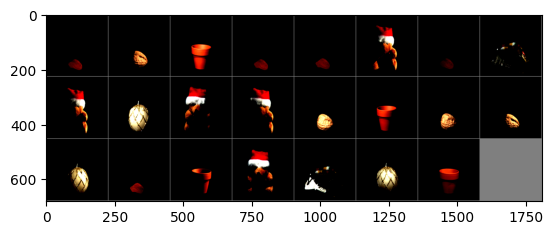

GroundTruth:  2 4 5 2
Predicted:  2 4 5 2


In [11]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show images and predictions
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(4)))
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{predicted[j]}' for j in range(4)))